In [16]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import os

In [14]:
def fetch_acq_files(user_name, acquistion_folder, device_name):
    path_name = os.path.join('~', 'Desktop', 'acqBIT')   
    path = os.path.expanduser(os.path.join(path_name, user_name, acquisition_folder,device_name))
    list_files = os.listdir(path)
    acq_files = [os.path.join(path, path_file)  for path_file in list_files if '.h5' in path_file]
    return acq_files

def get_channel_from_files(acq_files, channel_name):
    channels = []
    for file_path in acq_files:
        with h5.File(file_path, 'r') as f:
            r_group = f[f.keys()[0]]
            channel = r_group[channel_name][:]
            channels.append(channel)
    return channels

In [2]:
# create toy sine wave 
n = 3600*1000
t_s = np.linspace(0, 100, n).reshape(n, 1)
print t_s
f = 1
xi = np.pi
K = 255
signal = K * np.tan(2*f*np.pi*t_s + xi)

[[0.00000000e+00]
 [2.77777855e-05]
 [5.55555710e-05]
 ...
 [9.99999444e+01]
 [9.99999722e+01]
 [1.00000000e+02]]


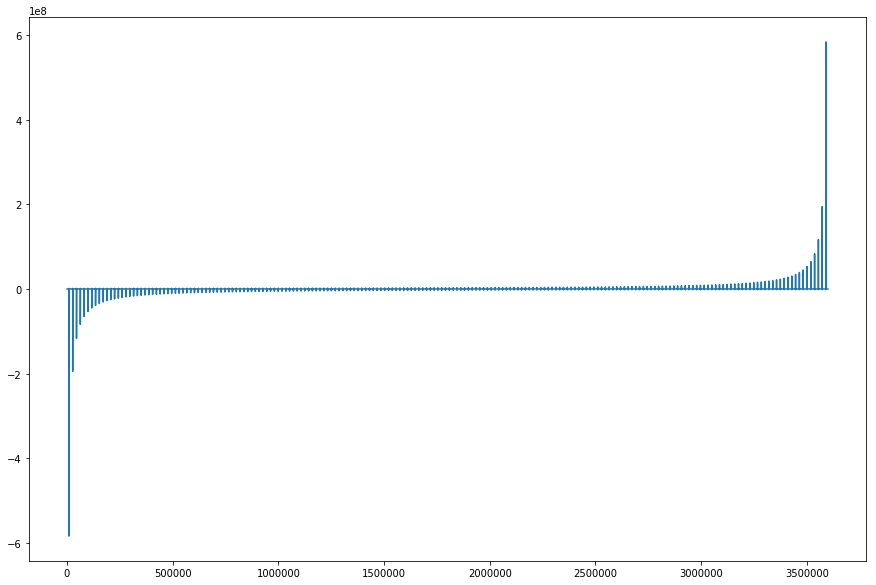

[[-3.12284934e-14]
 [ 4.45059087e-02]
 [ 8.90118202e-02]
 ...
 [-8.90118202e-02]
 [-4.45059087e-02]
 [-1.74721723e-12]]


In [3]:
plt.figure(figsize=(15, 10))
plt.plot(signal)
plt.show()

print signal

In [6]:
## dump toy signal with same dimension into openSignals file
path_file = 'C:\\Users\\franciscosargo\\Desktop\\opensignals_201607181669_2019-01-30_17-29-39.h5'
path_file_test = 'C:\\Users\\franciscosargo\\Desktop\\test.h5'
with h5.File(path_file, 'r+') as f, h5.File(path_file_test, 'w') as f_test:
    r_group = f[f.keys()[0]]
    group_id = f_test.require_group('/')
    f.copy(r_group, group_id)

In [ ]:
## dump toy signal with same dimension into openSignals file
if False:
    path_file = 'C:\\Users\\franciscosargo\\Desktop\\test.h5'
    with h5.File(path_file, 'r+') as f:
        r_group = f[f.keys()[0]]
        # Replace all ananalog channels with dummy siganl
        for i in xrange(1, 7):
            data = r_group['raw/channel_{}'.format(i)]
            data[...] = signal

In [ ]:
### Compute the specified metrics by the OpenSignals Documentation
if False:
    i = 1
    with h5.File(path_file_test, 'r+') as f_test:

        for i in [1, 2, 3, 4, 5, 6]:

            print i
            for level in [10, 100, 1000]:

                print level

                # Compute moving support statistics
                r_group = f_test[f_test.keys()[0]]
                data = r_group['raw/channel_{}'.format(i)]
                Mx = np.array([max(data[c:c+level]) for c in xrange(0, len(data), level)])
                mx = np.array([min(data[c:c+level]) for c in xrange(0, len(data), level)])
                mean = np.array([np.mean(data[c:c+level]) for c in xrange(0, len(data), level)])
                mean_x2 = np.array([np.mean(data[c:c+level])**2 for c in xrange(0, len(data), level)])
                sd = np.array([np.std(data[c:c+level])**2 for c in xrange(0, len(data), level)])
                t = np.array(xrange(0, len(data), level))

                # Change the data on disk
                data = r_group['support/level_{}/channel_{}/Mx'.format(level, i)]
                data[...] = Mx.reshape(len(Mx), 1)

                data = r_group['support/level_{}/channel_{}/mean'.format(level, i)]
                data[...] = mean.reshape(len(Mx), 1)

                data = r_group['support/level_{}/channel_{}/mean_x2'.format(level, i)]
                data[...] = mean_x2.reshape(len(Mx), 1)

                data = r_group['support/level_{}/channel_{}/mx'.format(level, i)]
                data[...] = mx.reshape(len(Mx), 1)

                data = r_group['support/level_{}/channel_{}/sd'.format(level, i)]
                data[...] = sd.reshape(len(Mx), 1)

                data = r_group['support/level_{}/channel_{}/t'.format(level, i)]
                data[...] = t.reshape(len(Mx), 1)

In [8]:
acqChannels = [1, 2, 3, 4, 5, 6]
length = len(signal)

nd_sequence = np.arange(0, length).reshape(length, 1)
nd_digital = np.zeros((length, 4))

# Set dummy all equal dummy analog channels
nd_analog = np.array([signal[:, 0] for i in acqChannels], copy=False).T

print nd_sequence.shape
print nd_digital.shape
print nd_analog.shape

ndsignal = np.concatenate((nd_sequence, nd_digital, nd_analog), axis=1)

(3600000L, 1L)
(3600000L, 4L)
(3600000L, 6L)


In [45]:
# Fetch created directory
user_name = 'New User'
acquisition_folder = '20190225-205628'
device_name = 'VR EDA'
acq_files = fetch_acq_files(user_name, acquisition_folder, device_name)[0:1]

# Get sequence number for acquisition
# Set names of the datasets, order according to the data array
nseq_dset_names = ['raw/nSeq']
digital_dset_names = ['digital/digital_{}'.format(dgNr + 1) for dgNr in xrange(0, 4)]
analog_dset_names = ['raw/channel_{}'.format(chNr + 1)  for chNr in xrange(0, 6)]

array = []
for channel_name in nseq_dset_names + digital_dset_names + analog_dset_names:
    array.append(get_channel_from_files(acq_files, channel_name)[0])

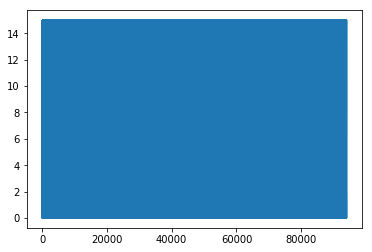

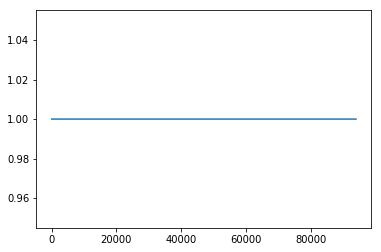

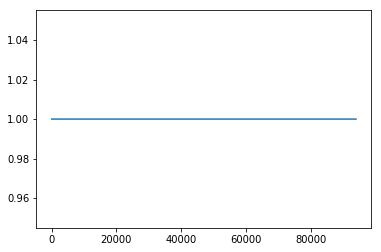

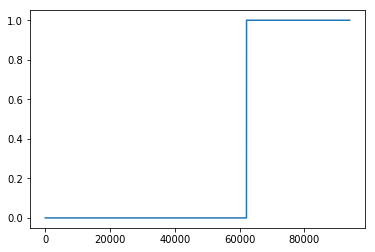

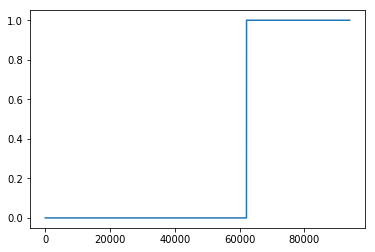

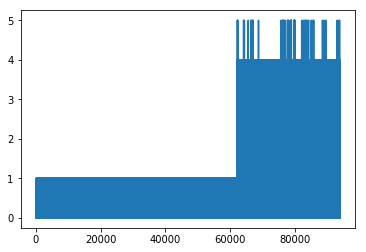

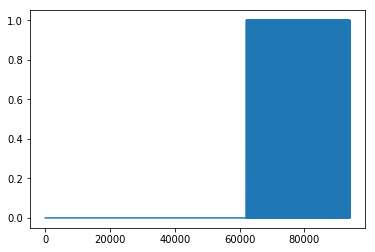

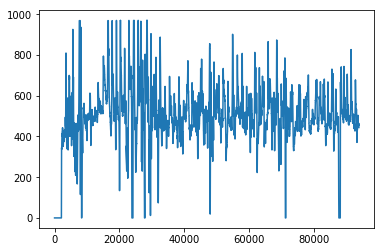

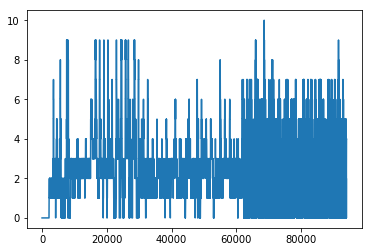

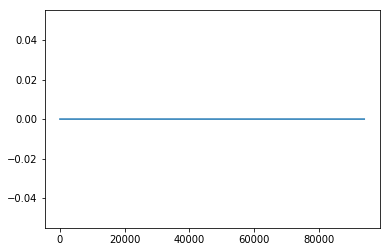

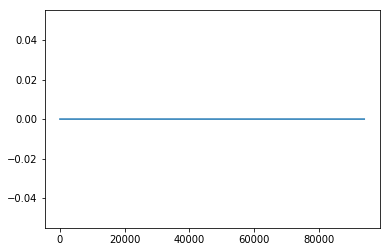

In [46]:
for channel in array:
    plt.figure()
    plt.plot(channel)

In [47]:
ndsignal = np.concatenate(array, axis=1)
print ndsignal.shape

(94000L, 11L)


In [48]:
def _write_acq_channel(r_group, channelName, channelSignal):
    """
    Write 1D signal from acquistion to the end of h5 dataset
    """
    # Write acquisition channel to h5 dset
    nSamples = channelSignal.shape[0]
    dset = r_group[channelName]
    nSamples_ds = dset.shape[0]
    dset.resize((nSamples_ds + nSamples, 1))
    dset[-nSamples:, 0] = channelSignal


def write_h5file(r_group, acqChannels, ndsignal):
    """ 
    Utility function to open and write to a previously opened h5 file for the acquisition
    """
    # Set names of the datasets, order according to the data array
    nseq_dset_names = ['raw/nSeq']
    digital_dset_names = ['digital/digital_{}'.format(dgNr + 1) for dgNr in xrange(0, 4)]
    analog_dset_names = ['raw/channel_{}'.format(chNr)  for chNr in acqChannels]
    dset_names = nseq_dset_names + digital_dset_names + analog_dset_names

    # Set the datasets on the file
    for i, dset_name in enumerate(dset_names):
        _write_acq_channel(r_group, dset_name, ndsignal[:, i])

        
def overwrite_dsets(r_group):

    # Set names of the datasets, order according to the data array
    nseq_dset_names = ['raw/nSeq']
    digital_dset_names = ['digital/digital_{}'.format(dgNr + 1) for dgNr in xrange(0, 4)]
    analog_dset_names = ['raw/channel_{}'.format(chNr + 1)  for chNr in xrange(0, 6)]
    dset_names = nseq_dset_names + digital_dset_names + analog_dset_names

    # Set the datasets on the file
    for dset_name in dset_names:
        print dset_name
        attrs = r_group[dset_name].attrs
        del r_group[dset_name]
        r_group.create_dataset(dset_name, 
                               dtype='uint16', shape=(0, 1), 
                               maxshape=(None, 1), chunks=(1024, 1))

        for k in attrs.keys():
            # Set attributes of the new dataset
            r_group[dset_name].attrs[k] = attrs[k]
                        

def open_h5file_os(path_file):
    dummy_path_file = 'C:\\Users\\franciscosargo\\Desktop\\opensignals_201604120230_2019-02-03_13-53-11.h5'
    ## Copy the contents from the dummy file
    with h5.File(dummy_path_file, 'r+') as dummy_f, h5.File(path_file, 'w') as f:
        r_group = dummy_f[dummy_f.keys()[0]]
        group_id = f.require_group('/')
        dummy_f.copy(r_group, group_id)

        
def support_metrics(array):
    Mx = array.max()
    mx = array.min()
    mean = np.mean(array)
    mean_x2 = np.mean(array)**2
    sd = np.std(array)
    return np.array([Mx, mx, mean, mean_x2, sd])


def _compute_support(r_group, channel_name, support_channel_name, level):
    data = r_group[channel_name]
    channel_name = support_channel_name
    #print channel_name
    
    if len(data) > level:
        sp = np.array(map(support_metrics, [data[c:c+level] for c in xrange(0, len(data), level)]), copy=False)
        t = np.array(xrange(0, len(data), level))
        length = len(t)

        # Change the data on disk
        dset_name = 'support/level_{}/{}/Mx'.format(level, channel_name)
        data = r_group[dset_name]
        del r_group[dset_name]
        r_group.create_dataset(dset_name, dtype='uint16', data=sp[:, 0].reshape(length, 1))
        
        dset_name = 'support/level_{}/{}/mx'.format(level, channel_name)
        data = r_group[dset_name]
        del r_group[dset_name]
        r_group.create_dataset(dset_name, dtype='uint16', data=sp[:, 1].reshape(length, 1))
        
        dset_name = 'support/level_{}/{}/mean'.format(level, channel_name)
        data = r_group[dset_name]
        del r_group[dset_name]
        r_group.create_dataset(dset_name, dtype='uint16', data=sp[:, 2].reshape(length, 1))
        
        dset_name = 'support/level_{}/{}/mean_x2'.format(level, channel_name)
        data = r_group[dset_name]
        del r_group[dset_name]
        r_group.create_dataset(dset_name, dtype='uint16', data=sp[:, 3].reshape(length, 1))
        
        dset_name = 'support/level_{}/{}/sd'.format(level, channel_name)
        data = r_group[dset_name]
        del r_group[dset_name]
        r_group.create_dataset(dset_name, dtype='uint16', data=sp[:, 4].reshape(length, 1))
        
        dset_name = 'support/level_{}/{}/t'.format(level, channel_name)
        data = r_group[dset_name]
        del r_group[dset_name]
        r_group.create_dataset(dset_name, dtype='uint16', data=t.reshape(length, 1))

        
def compute_support(r_group, acqChannels, levels):
    digital_dset_names = ['digital/digital_{}'.format(dgNr) for dgNr in xrange(1, 4)]
    digital_support_dset_names = ['dig_channel_{}'.format(dgNr) for dgNr in xrange(1, 4)]
    analog_dset_names = ['raw/channel_{}'.format(chNr)  for chNr in acqChannels]
    analog_dset_support_names = ['channel_{}'.format(chNr)  for chNr in acqChannels]
    dset_names = digital_dset_names + analog_dset_names
    support_dset_names = digital_support_dset_names + analog_dset_support_names
    
    for channel_name, support_channel_name in zip(dset_names, support_dset_names):
        #print channel_name
        #print support_channel_name
        for level in levels:
            #print level
            _compute_support(r_group, channel_name, support_channel_name, level)
    
    
path_file = 'C:\\Users\\franciscosargo\\Desktop\\good_file.h5'
open_h5file_os(path_file)
with h5.File(path_file) as f:
    r_group = f[f.keys()[0]]
    overwrite_dsets(r_group)
    write_h5file(r_group, acqChannels, ndsignal)
    compute_support(r_group, acqChannels, [10, 100, 1000])
      
#replace_dsets(path_file, signal)


# with h5.File(path_file_test, 'r+') as f_test:
    
#     # Compute moving support statistics
#     r_group = f_test[f_test.keys()[0]]
    
#     [compute_support(r_group, i, level) for i in xrange(1, 7, 1)
#                                         for level in [10, 100, 1000]]

raw/nSeq
digital/digital_1
digital/digital_2
digital/digital_3
digital/digital_4
raw/channel_1
raw/channel_2
raw/channel_3
raw/channel_4
raw/channel_5
raw/channel_6


In [ ]:
def support_metrics(array):
    Mx = array.max(axis=0)
    mx = array.min(axis=0)
    mean = np.mean(array, axis=0)
    mean_x2 = np.mean(array, axis=0)**2
    sd = np.std(array, axis=0)
    return np.stack((Mx, mx, mean, mean_x2, sd))


### Statistical Computation of samples test
for level in [10, 100, 1000]:
    N = n/level
    list_split = np.array_split(ndsignal[:, 1:], N)
    support = np.array(map(support_metrics, list_split), copy=False)

In [ ]:
print support[-1].shape